In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F

In [2]:
train_transforms = transforms.Compose([
    # transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    # transforms.CenterCrop(18),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.13252,), (0.31048,))
    ])

In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transforms,
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=test_transforms,
)

In [4]:
import numpy as np
labels = np.array(training_data.targets)
unique, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count}")

Label 0: 5923
Label 1: 6742
Label 2: 5958
Label 3: 6131
Label 4: 5842
Label 5: 5421
Label 6: 5918
Label 7: 6265
Label 8: 5851
Label 9: 5949


In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, pin_memory=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


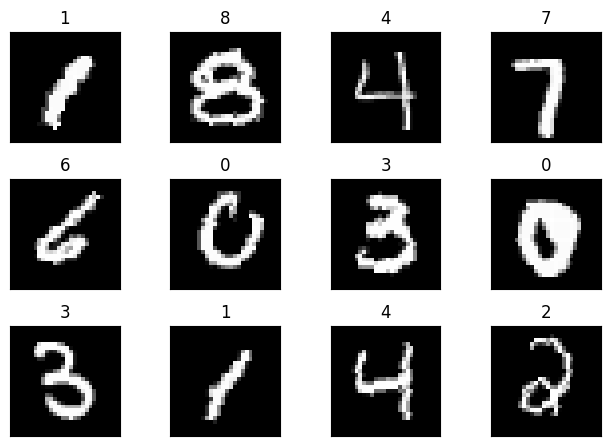

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_dataloader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [7]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [56]:
class MnistFullyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # First block
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.BatchNorm2d(8),
            # nn.Dropout(p=0.05),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), # 28x28 -> 28x28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(p=0.05),
            nn.MaxPool2d(2, 2)  # 28x28 -> 14x14
        )
        
        # Second block
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), # 14x14 -> 14x14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            # nn.Dropout(p=0.05),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 14x14 -> 14x14
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.05),
            nn.MaxPool2d(2, 2)  # 14x14 -> 7x7
        )
        
        # Third block
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1), # 7x7 -> 7x7
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(p=0.05),
            nn.Conv2d(32, 16, kernel_size=1, stride=1)  # 1x1 conv for dimension reduction
        )
        
        # Final classification layer - fully convolutional
        self.block4 = nn.Sequential(
            nn.Conv2d(16, 10, kernel_size=1, stride=1),  # 1x1 conv for 10 classes
            nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 10)
        return x

model = MnistFullyCNN()
model = model.to(device)
print(model)

MnistFullyCNN(
  (block1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.05, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0

In [9]:
# !pip install torch-summary

In [10]:
from torchsummary import summary

summary(model, (1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 14, 14]          --
|    └─Conv2d: 2-1                       [-1, 8, 28, 28]           80
|    └─ReLU: 2-2                         [-1, 8, 28, 28]           --
|    └─BatchNorm2d: 2-3                  [-1, 8, 28, 28]           16
|    └─Conv2d: 2-4                       [-1, 16, 28, 28]          1,168
|    └─ReLU: 2-5                         [-1, 16, 28, 28]          --
|    └─BatchNorm2d: 2-6                  [-1, 16, 28, 28]          32
|    └─Dropout: 2-7                      [-1, 16, 28, 28]          --
|    └─MaxPool2d: 2-8                    [-1, 16, 14, 14]          --
├─Sequential: 1-2                        [-1, 32, 7, 7]            --
|    └─Conv2d: 2-9                       [-1, 16, 14, 14]          2,320
|    └─ReLU: 2-10                        [-1, 16, 14, 14]          --
|    └─BatchNorm2d: 2-11                 [-1, 16, 14, 14]          32
|    └─Co

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 14, 14]          --
|    └─Conv2d: 2-1                       [-1, 8, 28, 28]           80
|    └─ReLU: 2-2                         [-1, 8, 28, 28]           --
|    └─BatchNorm2d: 2-3                  [-1, 8, 28, 28]           16
|    └─Conv2d: 2-4                       [-1, 16, 28, 28]          1,168
|    └─ReLU: 2-5                         [-1, 16, 28, 28]          --
|    └─BatchNorm2d: 2-6                  [-1, 16, 28, 28]          32
|    └─Dropout: 2-7                      [-1, 16, 28, 28]          --
|    └─MaxPool2d: 2-8                    [-1, 16, 14, 14]          --
├─Sequential: 1-2                        [-1, 32, 7, 7]            --
|    └─Conv2d: 2-9                       [-1, 16, 14, 14]          2,320
|    └─ReLU: 2-10                        [-1, 16, 14, 14]          --
|    └─BatchNorm2d: 2-11                 [-1, 16, 14, 14]          32
|    └─Co

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # 0.001

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (image, label) in enumerate(dataloader):
        image, label = image.to(device), label.to(device)

        # Compute prediction error
        pred = model(image)
        loss = loss_fn(pred, label)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += loss_fn(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.344753  [   64/60000]
loss: 1.578334  [ 3264/60000]
loss: 1.003843  [ 6464/60000]
loss: 0.483766  [ 9664/60000]
loss: 0.391251  [12864/60000]
loss: 0.339378  [16064/60000]
loss: 0.131558  [19264/60000]
loss: 0.101534  [22464/60000]
loss: 0.263971  [25664/60000]
loss: 0.118621  [28864/60000]
loss: 0.087504  [32064/60000]
loss: 0.100261  [35264/60000]
loss: 0.115743  [38464/60000]
loss: 0.093647  [41664/60000]
loss: 0.096310  [44864/60000]
loss: 0.201479  [48064/60000]
loss: 0.206206  [51264/60000]
loss: 0.122192  [54464/60000]
loss: 0.073539  [57664/60000]
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.086012 

Done!


# Saving and loading model

In [30]:
model_path = "models/mnist_fully_cnn.pth"
torch.save(model.state_dict(), model_path)
print(f"Saved PyTorch Model State to {model_path}")

Saved PyTorch Model State to models/mnist_fully_cnn.pth


In [52]:
model_loaded = MnistFullyCNN().to(device)
model_loaded.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

In [53]:
# Prediction using loaded model
model_loaded.eval()
image, label = test_data[0]
with torch.no_grad():
    image = image.to(device)
    pred = model_loaded(image.unsqueeze(0))
    predicted, actual = pred[0].argmax(0), label
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "1", Actual: "7"


In [54]:
pred[0]

tensor([-2.3335, -2.1291, -2.1451, -2.6714, -2.1757, -2.5301, -2.5060, -2.2678,
        -2.2155, -2.2030], device='mps:0')

In [55]:
nn.Softmax(dim=1)(pred)

tensor([[0.0970, 0.1189, 0.1171, 0.0692, 0.1135, 0.0797, 0.0816, 0.1035, 0.1091,
         0.1105]], device='mps:0')

# Dataset Class

In [27]:
import os
import pandas as pd
from torchvision.io import decode_image

class CustomMnistDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [28]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device
